# Solving Maxwell's equations with convolutional neural networks

In [3]:
import h5py

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from angler import Simulation

from datasets.generators import *
from models.utils import pbar

# import keras
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, ConvLSTM2D, Reshape, Permute

In [2]:
permittivities, proximities, Hx, Hy, Ez = load_batch("datasets/test.hdf5", "rectangles")

In [7]:
# inputs = Input(shape=(64, 64, 1))#, 2))

# x = Conv2D(16, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
# x = Conv2D(32, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# outputs = Reshape((32, 32))(x)

# model = Model(inputs=inputs, outputs=outputs)

inputs = Input(shape=(64, 64, 2))

x = Conv2D(16, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
x = Conv2D(32, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(128,kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(1,  kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
outputs = Reshape((32, 32))(x)

model = Model(inputs=inputs, outputs=outputs)

In [8]:
model.compile(loss=keras.losses.mean_squared_logarithmic_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 16)        3888      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        61984     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        102464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [9]:
x_data = np.stack((permittivities, proximities), axis=-1)
y_data = np.abs(Ez)[:,16:48, 16:48]
y_data_shit = permittivities[:, 16:48, 16:48]

In [10]:
x_data.shape

(2000, 64, 64, 2)

In [79]:
# Device configuration
device = torch.device('cpu')

# Hyperparameters
num_epochs = 1
batch_size = 50
learning_rate = 0.001

class PermittivityDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, hdf5_file, batch_name):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.permittivities, self.proximities, self.Hx, self.Hy, self.Ez = load_batch(hdf5_file, batch_name)
#         self.labels = np.abs(self.Ez[:, 16:48, 16:48])
        self.labels = self.permittivities[:, 16:48, 16:48]

    def __len__(self):
        return len(self.permittivities)

    def __getitem__(self, i):
        return torch.tensor([self.permittivities[i], self.proximities[i]]).float(), torch.tensor(self.labels[i]).float()
    

permittivity_data = PermittivityDataset("datasets/test.hdf5", "rectangles")
train_size = int(0.9 * len(permittivity_data))
test_size = len(permittivity_data) - train_size
train_data, test_data = random_split(permittivity_data, [train_size, test_size])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        conv_channels = [16, 32, 64, 64, 64, 128, 64, 1]
        kernel_sizes = [11, 11, 5, 5, 3, 3, 1, 1]
        
        layers = []
        
        in_channels=2 # number of input channels
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers.append(nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0), nn.ReLU()))
            in_channels = out_channels
        
        self.convolutions = nn.ModuleList(layers)
        
    def forward(self, x):
        out = x
        for layer in self.convolutions:
            out = layer(out)
        out = out.reshape((batch_size, 32, 32))
        return out

model = ConvNet().to(device)


# Loss and optimizer
# def SquaredLogLoss(yhat, y):
#     return torch.square(torch.log(yhat) - torch.log(y))

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=0.1)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    
    for data, fields in pbar(train_loader):
        data = data.to(device)
        fields = fields.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, fields)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [80]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
data_list = []
labels_list = []
outputs_list = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        data_list.append(data)
        labels_list.append(labels)
        outputs_list.append(outputs)

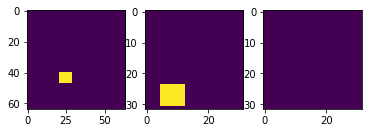

In [81]:
n = np.random.randint(0,4)
m = np.random.randint(0,batch_size)
permittivity = data_list[n][m][0]
label = labels_list[n][m]
predicted = outputs_list[n][m]

f, axarr = plt.subplots(1,3)
axarr[0].imshow(permittivity)
axarr[1].imshow(label)
axarr[2].imshow(predicted)

In [ ]:
class ConvMaxwellModel:
    
    def __init__(self, batch_size=128, learning_rate=1e-4):
        self._batch_size = batch_size
        self._learning_rate = learning_rate

    def inference(self, images, keep_prob):
        with tf.variable_scope('conv1') as scope:
            kernel = self._create_weights([5, 5, 1, 32])
            conv = self._create_conv2d(images, kernel)
            bias = self._create_bias([32])
            preactivation = tf.nn.bias_add(conv, bias)
            conv1 = tf.nn.relu(preactivation, name=scope.name)
            self._activation_summary(conv1)

        # pool 1
        h_pool1 = self._create_max_pool_2x2(conv1)

        with tf.variable_scope('conv2') as scope:
            kernel = self._create_weights([5, 5, 32, 64])
            conv = self._create_conv2d(h_pool1, kernel)
            bias = self._create_bias([64])
            preactivation = tf.nn.bias_add(conv, bias)
            conv2 = tf.nn.relu(preactivation, name=scope.name)
            self._activation_summary(conv2)

        # pool 2
        h_pool2 = self._create_max_pool_2x2(conv2)

        with tf.variable_scope('local1') as scope:
            reshape = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
            W_fc1 = self._create_weights([7 * 7 * 64, 1024])
            b_fc1 = self._create_bias([1024])
            local1 = tf.nn.relu(tf.matmul(reshape, W_fc1) + b_fc1, name=scope.name)
            self._activation_summary(local1)

        with tf.variable_scope('local2_linear') as scope:
            W_fc2 = self._create_weights([1024, self._num_labels])
            b_fc2 = self._create_bias([self._num_labels])
            local1_drop = tf.nn.dropout(local1, keep_prob)
            local2 = tf.nn.bias_add(tf.matmul(local1_drop, W_fc2), b_fc2, name=scope.name)
            self._activation_summary(local2)
        return local2

    def train(self, loss, global_step):
        tf.summary.scalar('learning_rate', self._learning_rate)
        train_op = tf.train.AdamOptimizer(self._learning_rate).minimize(loss, global_step=global_step)
        return train_op

    def loss(self, logits, labels):
        with tf.variable_scope('loss') as scope:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
            cost = tf.reduce_mean(cross_entropy, name=scope.name)
            tf.summary.scalar('cost', cost)

        return cost

    def accuracy(self, logits, labels):
        with tf.variable_scope('accuracy') as scope:
            accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), dtype=tf.float32),
                                      name=scope.name)
            tf.summary.scalar('accuracy', accuracy)
        return accuracy

    def _create_conv2d(self, x, W):
        return tf.nn.conv2d(input=x,
                            filter=W,
                            strides=[1, 1, 1, 1],
                            padding='SAME')

    def _create_max_pool_2x2(self, input):
        return tf.nn.max_pool(value=input,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')

    def _create_weights(self, shape):
        return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1, dtype=tf.float32))

    def _create_bias(self, shape):
        return tf.Variable(tf.constant(1., shape=shape, dtype=tf.float32))

    def _activation_summary(self, x):
        tensor_name = x.op.name
        tf.summary.histogram(tensor_name + '/activations', x)
        tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

In [7]:
history = model.fit(x_data, y_data_shit,
                    epochs=1,
                    verbose=1,
                    validation_split = 0.1,
                    callbacks=[keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq=32)])

Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 68s 38ms/step - loss: 3.7236 - acc: 0.6875 - val_loss: 2.5602 - val_acc: 0.7080


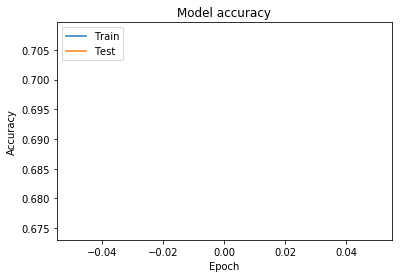

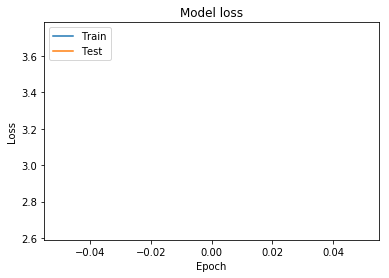

In [57]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
N = np.random.randint(0,2000)
x_pred = x_data[N:N+1]
y_real = y_data[N:N+1]

y_pred = model.predict(x_pred)

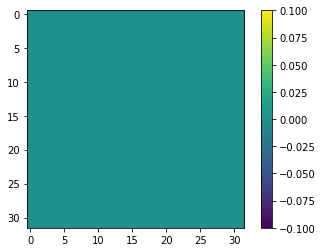

In [59]:
plt.imshow(y_pred[0])
plt.colorbar()
plt.show()

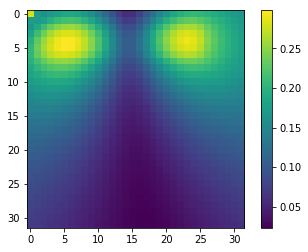

In [60]:
plt.imshow(y_real[0])
plt.colorbar()
plt.show()

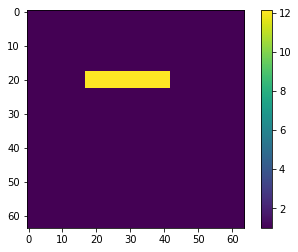

In [61]:
plt.imshow(x_pred[0,:,:,0])
plt.colorbar()
plt.show()